<a href="https://colab.research.google.com/github/JonathaCosta/3_SmartGrid/blob/main/AEL/rad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise em Time Série


# Classes


## Classe AnalisePrevisão

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


class AnalisePrevisao():
  '''
  Classe com métodos de previsão para séries temporais utilizando poucas variáveis
  globais para dar maior flexibilidade às chamadas externas dos métodos para anaĺise
  variando períodos e train-test subset da cada chamada.

  Alerta: Métodos analisam apenas uma coluna(variável) do timeseries por vez.
  # coluna_analise
  '''
  def __init__(self,df):
     # Método init dados e a coluna que será utilizada como index.
     try:
        self.df = df
        #print('Objeto instanciado com sucesso! Faça uso dos métodos com maestria!')                      

     except:
        print('Erro de entrada')


  def periodo(self):  
    dia = self.df.resample('D').sum()
    semana = self.df.resample('W').sum()
    mes = self.df.resample('M').sum()
    return dia,semana,mes

  def forecast(self,df):
    # Período futuro para forecast
    '''lista = {'<Day>':'D'}
    freq = df.index.freq
    try:
      for i,j in lista:
        if i == freq:
          freq = j
      except:
        pass
      else:
        print('Não é possível prever o próximo período! Reveja a freq do dataset.')  
   '''
    return df.index[-1] + np.timedelta64(1,'D') 
    # ***************************************************************************
    #  PENDÊNCIA: Construir método para identificar a freq do df e sugerir o próximo período!
    # ***************************************************************************


  def sep_train_test(self,df):
    # Separação do conjunto de dados para teste e treinamentos    
    
    corte = int(len(df)*2/3) 
    train_set = df[:corte]
    test_set  = df[corte:]
    return train_set,test_set

  def graf(self, metodo, train_set,test_set, previsoes, erro, n=None, forecast=None):
  # Opção de análise gráfica com datasérie diferentes
    
    plt.figure(figsize=(15,6))
    plt.plot(train_set)
    plt.plot(test_set)
    plt.plot(previsoes)
    plt.title(f'Modelo e previsões com {metodo} e config: {n}. RMSE: {erro}')
    plt.legend(['Treino','Teste','Previsão'])  

    

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Classe métodos estatísticos


In [ ]:

class MetodosPrevisao(AnalisePrevisao):

  '''Classe com os métodos estatístics de previsão de séries temporais:
  AR, ARMA, ARIMA e SARIMA.
  '''
  def __init__(self,df):
    AnalisePrevisao.__init__(self,df)

  #Método 1 - AR
  def ar(self, df, n, graf = None):
    # Modelo ar e teste e 'n' configurações 
    freq = df.index.freq
    train_set,test_set = self.sep_train_test(df)

    ar = AR(train_set, freq = freq).fit(n)
    
    # Recebe os parâmetros do modelo treinado e aplica no conjunto de teste
    previsoes = ar.params[0]
    for i,coef in enumerate(ar.params[1:]):
      previsoes+= coef * test_set.shift(i+1)
      erro = round((((test_set - previsoes)**2).mean())**0.5,2)
   
    if graf==1:
      self.graf('AR',train_set, test_set, previsoes, erro, n)
    else: 
      None  

    return erro, previsoes 
#*********************************************************************************<< TRABALHANDO AQUI!!!!
  #Método 2 - ARMA
  def arma(self,df, graf = 0):
    # Modelo arma e teste e 'n' configurações
    freq = df.index.freq
    train_set,test_set = self.sep_train_test(df)

    configs = [(4,4),(4,3),(4,2),(4,1),
               (3,4),(3,3),(3,2),(3,1),
               (2,4),(2,3),(2,2),(2,1),
               (1,4),(1,3),(1,2),(1,1)]
    best = 1000

    # Modelo aprende os parâmetro em trains_set e testa-os em test_set
    for i in configs:
      try:
        arma_train = ARMA(train_set, freq = freq, order = i).fit()
        arma_test = ARMA(test_set, freq = freq, order = i).fit(arma_train.params)
        erro = round(((arma_test.resid **2).mean())**0.5,2)
        if erro < best:
           best = erro
           print(i,erro,arma_test.predict()[0])
           
      except:    
        pass
    
    
    previsoes = arma_test.predict()
    forecast = arma_test.predict(start = self.forecast(df) ,end = self.forecast(df))

    if graf==1:
      self.graf('ARMA',previsoes,best,i)
    else: 
      None  

    return erro, previsoes,forecast 

  #Método 3 - ARIMA

  def arima(self,freq, graf = 0):
    # Modelo arima e teste e 'n' configurações
    configs = [(3,1,3),(3,1,2),(3,1,1),(3,1,0),
               (2,1,3),(2,1,2),(2,1,1),(2,1,0),
               (1,1,3),(1,1,2),(1,1,1),(1,1,0),               
               ]
    best = 1000

    # Modelo aprende os parâmetro em trains_set e testa-os em test_set
    for i in configs:
      try:
        arima_train = ARIMA(self.train_set, freq=freq, order = i).fit()
        arima_test = ARIMA(self.test_set, freq=freq, order = i).fit(arima_train.params)
        erro = round(((arima_test.resid **2).mean())**0.5,2)
        if erro < best:
           best = erro
           print(i,erro,arima_test.predict(typ='levels')[0])
           
      except:    
        print('fail')
        pass
    previsoes = arima_test.predict(typ='levels')
    forecast = arima_test.predict(start=self.periodo_futuro.day ,end=self.periodo_futuro.day)

    if graf==1:
      self.graf('ARIMA',previsoes,best,i)
    else: 
      None  

    return erro, previsoes,forecast 

  #Método 4 - SARIMA
  def sarima(self,freq, graf = 0):
    # Modelo sarima e teste e 'n' configurações
    configs = [(3,1,3),(3,1,2),(3,1,1),(3,1,0),
               (2,1,3),(2,1,2),(2,1,1),(2,1,0),
               (1,1,3),(1,1,2),(1,1,1),(1,1,0),               
               ]
    best = 1000

    # Modelo aprende os parâmetro em trains_set e testa-os em test_set
    for i in configs:
      try:
        sarima_train = SARIMAX(self.train_set, freq=freq, order = i,seasonal_order=(3,1,2,12)).fit()
        sarima_test = SARIMAX(self.test_set, freq=freq, order = i,seasonal_order=(3,1,2,12)).fit(sarima_train.params)
        erro = round(((sarima_test.resid **2).mean())**0.5,2)
        if erro < best:
           best = erro
           print(i,erro,sarima_test.predict(typ='levels')[0])
           
      except:    
        print('fail')
        pass
    previsoes = sarima_test.predict(typ='levels')
    forecast = sarima_test.predict(start=self.periodo_futuro.day ,end=self.periodo_futuro.day)

    if graf==1:
      self.graf('SARIMA',previsoes,best,i)
    else: 
      None  

    return erro, previsoes,forecast 
        
 

# Simulação

In [5]:
import pandas as pd
# Import e pré-processamento de dados

a='https://raw.githubusercontent.com/JonathaCosta/3_SmartGrid/main/Datasets/2017_FORTALEZA(A305).csv'
b='https://raw.githubusercontent.com/JonathaCosta/3_SmartGrid/main/Datasets/2018_FORTALEZA%20(A305).csv'
c='https://raw.githubusercontent.com/JonathaCosta/3_SmartGrid/main/Datasets/2019_FORTALEZA%20(A305).csv'
d='https://raw.githubusercontent.com/JonathaCosta/3_SmartGrid/main/Datasets/2020_FORTALEZA%20(A305).csv'
e='https://raw.githubusercontent.com/JonathaCosta/3_SmartGrid/main/Datasets/2021_FORTALEZA%20(A305).csv'

dados=pd.DataFrame()
for i in ([a,b,c,d,e]):
  df = pd.read_csv(i, sep=';',header=1,index_col='Data', decimal=',', parse_dates=True,infer_datetime_format=True)
  dados = pd.concat([dados,df])

dados.drop(dados.columns[-1],axis=1,inplace=True)
dados.rename(columns={'Hora (UTC)':'hora', 'Temp. Ins. (C)':'tinst', 'Temp. Max. (C)': 'tmax', 'Temp. Min. (C)':'tmin',
       'Umi. Ins. (%)': 'uinst', 'Umi. Max. (%)':'umax', 'Umi. Min. (%)':'umin',
       'Pto Orvalho Ins. (C)':'poinst', 'Pto Orvalho Max. (C)':'pomax', 'Pto Orvalho Min. (C)':'pomin',
       'Pressao Ins. (hPa)':'pinst', 'Pressao Max. (hPa)':'pmax', 'Pressao Min. (hPa)':'pmin',
       'Vel. Vento (m/s)':'velven', 'Dir. Vento (m/s)':'dirven', 'Raj. Vento (m/s)':'rajven',
       'Radiacao (KJ/m²)':'radiacao', 'Chuva (mm)':'chuva'},inplace=True)
df = dados.loc[:,['radiacao']]     # Comando loc[:,[]] manter o dataset como Dataframe. Comando dados.radiacao altera-o para Serie.
s = MetodosPrevisao(df)
dia,semana,mes = s.periodo()


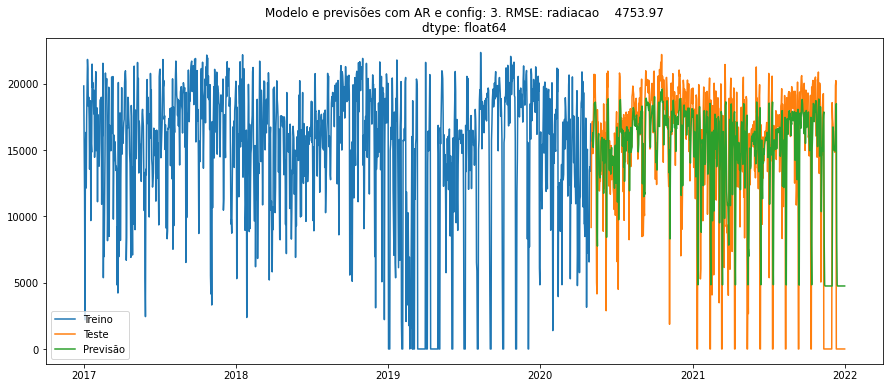

In [7]:
erro,prev = s.ar(dia,3,1)

In [ ]:
import numpy as np

def forecast(df):
  # Período futuro para forecast
  lista = {'<Day>':'D'}
  freq = str(df.index.freq)
  try:
    for i,j in lista:
      if i == freq:
        print(j)
  except:
      pass
  else:
      print('Não é possível prever o próximo período! Reveja a freq do dataset.')  

  

forecast(dia)

In [ ]:
str(dia.index.freq)


In [ ]:
df=dia.copy()

df.index[-1] + np.timedelta64(1,'D') 
